# Machine Learning Zoomcamp Homeworks

## Week 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [2]:
df = pd.read_csv('data\CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [3]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [4]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [5]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [6]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [7]:
columns_categorical = df.select_dtypes(include=['flexible', 'object', 'bool']).columns.to_list()
columns_numerical   = df.select_dtypes(include=['number']).columns.to_list()

print("Categorical Columns:\n", columns_categorical)
print("Numerical Columns:\n", columns_numerical)

Categorical Columns:
 ['home', 'marital', 'records', 'job']
Numerical Columns:
 ['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price', 'default']


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [8]:
from sklearn.model_selection import train_test_split

random_seed = 1
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=random_seed)
df_train, df_valid     = train_test_split(df_train_full, test_size=0.25, random_state=random_seed)

print(len(df), len(df_train), len(df_valid), len(df_test))

4454 2672 891 891


## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

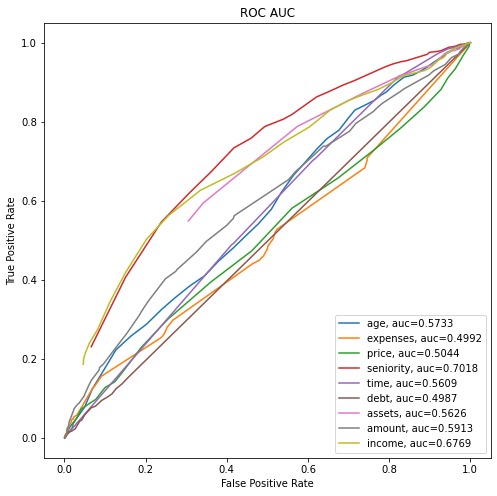

In [9]:
from sklearn.metrics import auc


def calculate_column_importance(df, column_name, target_column_name, invert=False):
    actual_positive = (df[target_column_name] == 1)
    actual_negative = (df[target_column_name] == 0)

    column_tpr, column_fpr = [], []
    column_values = -df[column_name] if invert else df[column_name]
    for threshold in np.linspace(column_values.min(), column_values.max(), 100):
        predict_positive = (column_values >= threshold)
        predict_negative = (column_values < threshold)

        column_tp = (predict_positive & actual_positive).sum()
        column_tn = (predict_negative & actual_negative).sum()
        column_fp = (predict_positive & actual_negative).sum()
        column_fn = (predict_negative & actual_positive).sum()

        tpr = column_tp / (column_tp + column_fn)
        fpr = column_fp / (column_fp + column_tn)

        column_tpr.append(tpr)
        column_fpr.append(fpr)

    column_auc = auc(column_fpr, column_tpr)
    if round(column_auc, 2) < 0.5:
        return calculate_column_importance(df, column_name, target_column_name, invert=True)
    return column_auc, column_tpr, column_fpr


plt.figure(figsize=(8, 8))

target_column = 'default'
score_columns = list(set(columns_numerical) - set([target_column]))

auc_scores = {}
for column in score_columns:
    column_auc, column_tpr, column_fpr = calculate_column_importance(df_train, column, target_column)
    plt.plot(column_fpr, column_tpr, label=column+', auc='+str(round(column_auc, 4)))
    auc_scores[column] = {'auc_score': column_auc, 'tpr': column_tpr, 'fpr': column_fpr}

plt.title('ROC AUC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

In [10]:
auc_scores_only = {column: values['auc_score'] for column, values in auc_scores.items()}
print({k: v for k, v in sorted(auc_scores_only.items(), key=lambda item: item[1], reverse=True)})

{'seniority': 0.7017699731473966, 'income': 0.6768705398034989, 'amount': 0.5912765609164017, 'age': 0.5732919341188272, 'assets': 0.5626323909961933, 'time': 0.5608662489595051, 'price': 0.5043995082246981, 'expenses': 0.4992222845261439, 'debt': 0.4986528421617216}


The sorted values for AUC scores indicates that 'seniority' column has the highest AUC.

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [11]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression


desired_columns = ['seniority', 'income', 'assets', 'records', 'job', 'home']

y_train = df_train[target_column].to_numpy()
y_valid = df_valid[target_column].to_numpy()
y_test  = df_test[target_column].to_numpy()

del df_train[target_column]
del df_valid[target_column]
del df_test[target_column]


train_dict = df_train[desired_columns].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [12]:
from sklearn.metrics import roc_auc_score


val_dict = df_valid[desired_columns].to_dict(orient='records')
X_valid = dv.transform(val_dict)

y_pred = model.predict_proba(X_valid)[:, 1]
target_pred = y_pred > 0.5

pred_score = (y_valid == target_pred).mean()
print('<<Accuracy Score>>\n > Actual: {}\n > Rounded: {}\n'.format(pred_score, round(pred_score, 2)))

auc_score = roc_auc_score(y_valid, y_pred)
print('<<AUC Score>>\n > Actual: {}\n > Rounded: {}\n'.format(auc_score, round(auc_score, 3)))

<<Accuracy Score>>
 > Actual: 0.7800224466891134
 > Rounded: 0.78

<<AUC Score>>
 > Actual: 0.8120879813449298
 > Rounded: 0.812



## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars


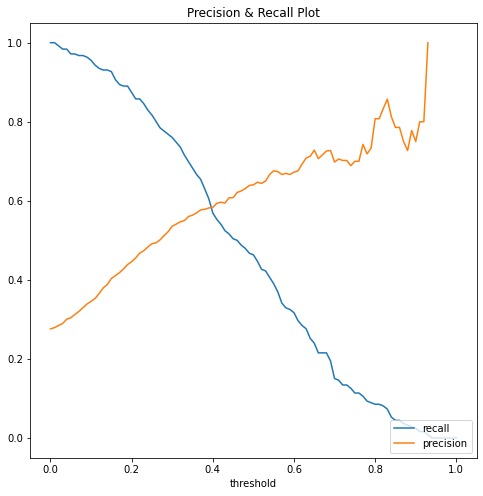

In [13]:
def create_evaluation_metrics(y_valid, y_pred, thresholds):
    metrics = []

    for t in thresholds:
        actual_positive  = (y_valid == 1)
        actual_negative  = (y_valid == 0)
        predict_positive = (y_pred  >= t)
        predict_negative = (y_pred  <  t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)

        accuracy = (tp + tn) / (tp + tn + fp + fn)
        recall = tpr  # recall = true positive rate = sensitivity
        precision = tp / (tp + fp)
        specificity = tn / (tn + fp)
        f1 = (2 * precision * recall) / (precision + recall)

        metrics.append((t, tp, tn, fp, fn, tpr, fpr, accuracy, recall, precision, specificity, f1))

    metric_columns = ['threshold', 'tp', 'tn', 'fp', 'fn', 'tpr', 'fpr', 'accuracy', 'recall', 'precision', 'specificity', 'f1']
    metric_scores  = pd.DataFrame(data=metrics, columns=metric_columns)

    return metric_scores


thresholds = np.arange(0, 1.01, 0.01)
metric_scores = create_evaluation_metrics(y_valid, y_pred, thresholds)


plt.figure(figsize=(8, 8))
plt.plot(metric_scores['threshold'], metric_scores['recall'], label='recall')
plt.plot(metric_scores['threshold'], metric_scores['precision'], label='precision')
plt.xlabel('threshold')
plt.title('Precision & Recall Plot')
plt.legend(loc='lower right')
plt.show()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

In [14]:
intersection_index = (metric_scores['precision'] - metric_scores['recall']).abs().argmin()
metric_scores.iloc[intersection_index]['threshold']

0.4

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [15]:
# already computed in metrics

metric_scores['f1']

0      0.432718
1      0.436557
2      0.442430
3      0.447734
4      0.460514
         ...   
96          NaN
97          NaN
98          NaN
99          NaN
100         NaN
Name: f1, Length: 101, dtype: float64

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

In [16]:
max_f1_index = (metric_scores['f1']).argmax()
metric_scores.iloc[max_f1_index]['threshold']

0.3

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [17]:
from sklearn.model_selection import KFold


num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)

target_column = 'default'
# train_columns = list(set(columns_numerical+columns_categorical) - set([target_column]))
fold_scores = {}
for fold_id, (train_idx, valid_idx) in enumerate(kfold.split(df_train_full)):
    df_train = df_train_full.iloc[train_idx]
    df_valid = df_train_full.iloc[valid_idx]

    y_train = df_train[target_column].to_numpy()
    y_valid = df_valid[target_column].to_numpy()

    train_dict = df_train[desired_columns].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict)

    X_train = dv.transform(train_dict)
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    val_dict = df_valid[desired_columns].to_dict(orient='records')
    X_valid = dv.transform(val_dict)

    y_pred = model.predict_proba(X_valid)[:, 1]
    target_pred = y_pred > 0.5

    acc_score = (y_valid == target_pred).mean()
    auc_score = roc_auc_score(y_valid, y_pred)
    fold_scores[fold_id] = {'acc': acc_score, 'auc': auc_score}


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

In [18]:
auc_scores = [scores['auc'] for fold, scores in fold_scores.items()]
print(round(np.std(auc_scores), 3))


0.015


calculated standard deviation equals '0.015' and the closest value to it would be '0.014'.

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [19]:
C_params = [0.01, 0.1, 1, 10]

c_scores = {}
for C in C_params:
    fold_scores = {}
    for fold_id, (train_idx, valid_idx) in enumerate(kfold.split(df_train_full)):
        df_train = df_train_full.iloc[train_idx]
        df_valid = df_train_full.iloc[valid_idx]

        y_train = df_train[target_column].to_numpy()
        y_valid = df_valid[target_column].to_numpy()

        train_dict = df_train[desired_columns].to_dict(orient='records')
        dv = DictVectorizer(sparse=False)
        dv.fit(train_dict)

        X_train = dv.transform(train_dict)
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        val_dict = df_valid[desired_columns].to_dict(orient='records')
        X_valid = dv.transform(val_dict)

        y_pred = model.predict_proba(X_valid)[:, 1]
        target_pred = y_pred > 0.5

        acc_score = (y_valid == target_pred).mean()
        auc_score = roc_auc_score(y_valid, y_pred)
        fold_scores[fold_id] = {'acc': acc_score, 'auc': auc_score}

    c_scores[C] = fold_scores


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [20]:
c_means_stds = {}
for C, scores in c_scores.items():
    auc_values = [fold_scores['auc'] for fold, fold_scores in scores.items()]
    mean_value = sum(auc_values) / num_folds
    std_value  = np.std(auc_values)
    c_means_stds[C] = {'mean': round(mean_value, 3), 'std': round(std_value, 3)}

print(c_means_stds)


{0.01: {'mean': 0.808, 'std': 0.012}, 0.1: {'mean': 0.813, 'std': 0.014}, 1: {'mean': 0.814, 'std': 0.015}, 10: {'mean': 0.814, 'std': 0.015}}


The scores indicate that the model with C=1 and C=10 achieve the best mean score (0.814) with also equal values for std (0.015). Therefore C=1 which is the smaller value among the two is selected as the answer according to question terms.